In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker, cm
import emcee                                          # Library for implementing the MCMC method
                                         # Library for plotting figures with contours and piramids.
from getdist import plots, MCSamples
from scipy.stats import scoreatpercentile
import arviz as az

In [2]:
#Load data from the file
datos = np.loadtxt('datos.txt')

# Extraer las columnas
x_data = datos[:, 0]
y_data = datos[:, 1]
error_y = datos[:, 2]

# We need to define the log likelihood and log posterior functions

def log_likelihood(params, x, y, error_y):
    a, b = params
    model = a*np.sin(0.5*x)+b
    residuals = (y - model) / error_y
    return -0.5 * np.sum(residuals**2)
def log_posterior(params, x, y, error_y):
    a, b = params
    if -20 < a < 20  and -20 < b < 20:
        logpost = log_likelihood(params, x, y, error_y)
    else:
        logpost = -np.inf
    #print(logpost)
    return logpost

In [3]:
# Load the backend from the existing file (put your path here)
reader    = emcee.backends.HDFBackend('/home/slandau/OneDrive/stats_peru/scripts/output_cadenas/prueba_2param.h5',read_only=True)
#Initialize the sampler
ndim     = 2                                 # number of parameters
nwalkers = 6           # number of walkers


# Get data from the backend without defining a new sampler
samples = reader.get_chain()
log_post = reader.get_log_prob()

# Define a new sampler without backend to analyze the results
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_data, y_data, error_y))


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_data, y_data, error_y),backend=reader)
# Initial guess for the parameters
init0=-18
init1=15
# print Number of steps of the chain to verify
print(reader.get_chain().shape)
#Minimum chi2 value
print(-np.max(log_post))




(9000, 6, 2)
8.677269444855671


#### Plot the chains


<Figure size 640x480 with 0 Axes>

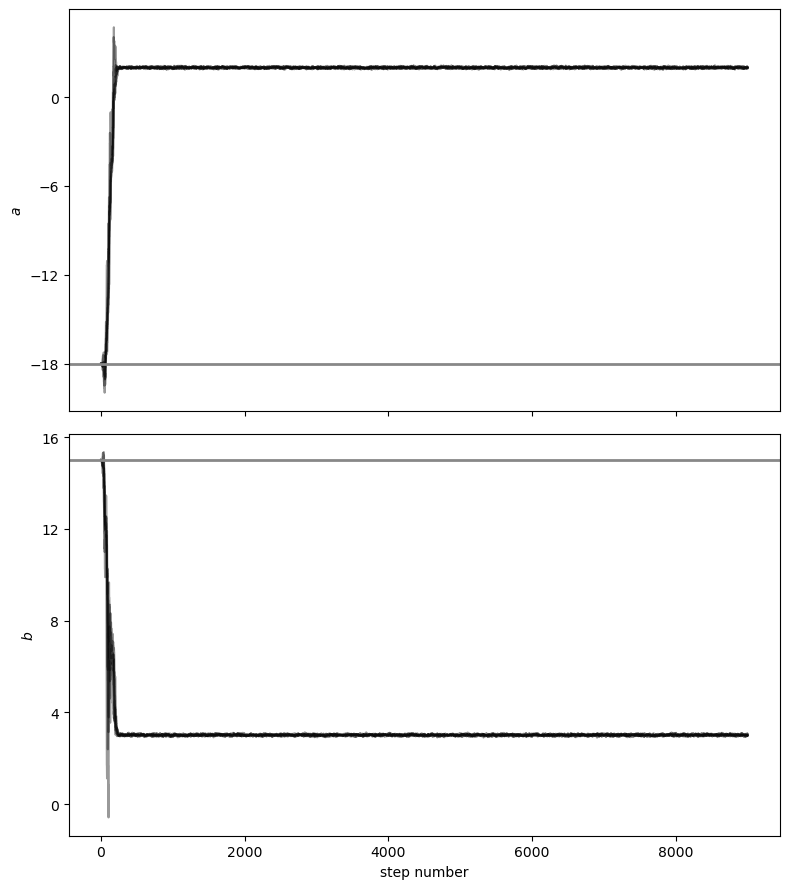

In [4]:
from matplotlib.ticker import MaxNLocator
plt.figure()
fig, ax = plt.subplots(ndim, 1, sharex=True, figsize=(8,9) )
ax0 = ax[0]
ax1 = ax[1]


ax0.plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4 )
ax0.yaxis.set_major_locator(MaxNLocator(5))
ax0.axhline(init0, color="#888888", lw=2)
ax0.set_ylabel("$a$")

ax1.plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
ax1.yaxis.set_major_locator(MaxNLocator(5))
ax1.axhline(init1, color="#888888", lw=2)
ax1.set_ylabel("$b$")
ax1.set_xlabel("step number")

fig.tight_layout()

# save figure with the chains
#fig.savefig('/home/slandau/OneDrive/stats_peru/scripts/chains_prueba.png')
#plt.xlim(0,3000)

plt.show()



<Figure size 640x480 with 0 Axes>

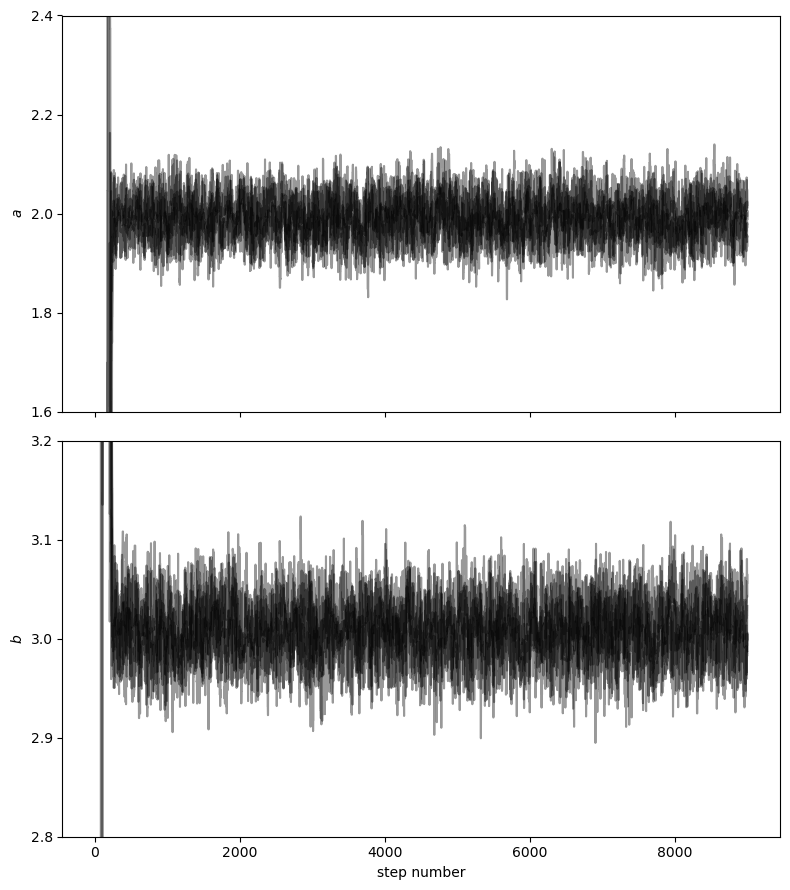

In [5]:
# Plot again the chains, changing the limits of the y axis
from matplotlib.ticker import MaxNLocator
plt.figure()
fig, ax = plt.subplots(ndim, 1, sharex=True, figsize=(8,9) )
ax0 = ax[0]
ax1 = ax[1]


ax0.plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4 )
ax0.yaxis.set_major_locator(MaxNLocator(5))
ax0.axhline(init0, color="#888888", lw=2)
ax0.set_ylim(1.6,2.4)
ax0.set_ylabel("$a$")

ax1.plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
ax1.yaxis.set_major_locator(MaxNLocator(5))
ax1.axhline(init1, color="#888888", lw=2)
ax1.set_ylim(2.8,3.2)
ax1.set_ylabel("$b$")
ax1.set_xlabel("step number")

fig.tight_layout()

# save figure with the chains
#fig.savefig('/home/slandau/OneDrive/stats_peru/scripts/chains_prueba.png')
#plt.xlim(0,3000)

plt.show()

#### Plot 2D contourplots and 1D Posteriors

[[1.98203789 3.01608493]
 [2.02006597 3.03750515]
 [2.03639187 2.98735117]
 ...
 [1.97980744 2.98590009]
 [2.01247613 2.99949083]
 [1.99583996 2.99829775]]
Removed no burn in


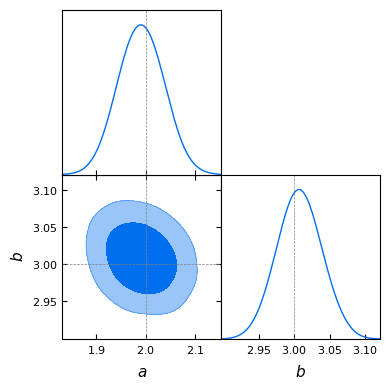

In [6]:

#Define burnin and thinning
burnin=int(0.05*len(samples[:,0])) ; thin=1
flat_samples = reader.get_chain(discard=burnin,flat=True)



print(flat_samples)

        

labels = ['a','b' ] 
names=['a','b']
ndim  = len(names)
samples1 = MCSamples(samples=flat_samples, names=names, labels=labels)
samples1 = samples1.copy(settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.5,
					'smooth_scale_1D':0.5})
g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],
g.triangle_plot(samples1,
                filled=True, params=names,
                #contour_colors=color,
                contour_lws=1,
#                param_limits={'a':(-6.9, 2),'b':(-37, -34)},
                 markers={'a':2,'b':3})

# save figure with the triangle plot
#filename_output = output+'triangle_plot.png'
#plt.savefig(filename_output)
plt.show()
plt.close()

#### Obtain 1D confidence intervals

In [7]:
# Después de crear el objeto samples1 de MCSamples
stats = samples1.getMargeStats()

# Para cada parámetro
for param in names:
    # Obtener los límites al 68% y 95% de confianza
    limits_68 = stats.parWithName(param).limits[0]  # 68% (1-sigma)
    limits_95 = stats.parWithName(param).limits[1]  # 95% (2-sigma)
    
    print(f"Parameter {param}:")
    print(f"  Mean Value: {stats.parWithName(param).mean:.5f}")
    #print(f"  Mediana: {stats.parWithName(param).median:.5f}")
    print(f"  68% CI: [{limits_68.lower:.5f}, {limits_68.upper:.5f}]")
    print(f"  95% CI: [{limits_95.lower:.5f}, {limits_95.upper:.5f}]")

Parameter a:
  Mean Value: 1.99078
  68% CI: [1.94835, 2.03337]
  95% CI: [1.91008, 2.07215]
Parameter b:
  Mean Value: 3.00766
  68% CI: [2.97887, 3.03642]
  95% CI: [2.95203, 3.06487]


In [9]:
params=2,3

print(-log_posterior(params, x_data, y_data, error_y))

8.72680674139796
